In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Avoid warnings
import warnings
warnings.filterwarnings("ignore")

# Import CSV Files

<h3>Checking and Cleaning data</h3>

In [2]:
#Checking the data
Cus_df =pd.read_csv("/kaggle/input/credit-card-exploratory-data-analysis/Customer Acqusition.csv")
Repay_df=pd.read_csv("/kaggle/input/credit-card-exploratory-data-analysis/Repayment.csv")
Spend_df=pd.read_csv("/kaggle/input/credit-card-exploratory-data-analysis/spend.csv")

Cus_cy_df=Cus_df.copy()
Repay_cy_df=Repay_df.copy()
Spend_cy_df=Spend_df.copy()

#Spend_df.sample(5)

In [3]:
# Checking for missing data

"""
No Missing Data 
Cus_df.isnull().sum()
Spend_df.isnull().sum()
Repay_df.isnull().sum() - missing data

"""
#Cus_df.describe(include='all')
#Spend_df.describe(include='all')
#Repay_df.describe(include='all')


'\nNo Missing Data \nCus_df.isnull().sum()\nSpend_df.isnull().sum()\nRepay_df.isnull().sum() - missing data\n\n'

In [4]:
#check num col and row in Repay_df
Repay_df.shape

#Drop Unnamed:4 column - it is uncessary columns
#Fill NAN with its index+1 in the columns SL No: - we might need it later on
Repay_cy_df = Repay_cy_df.drop(labels='Unnamed: 4', axis=1)
Repay_cy_df['SL No:'] = Repay_cy_df.index+1
Repay_cy_df = Repay_cy_df.dropna()
Repay_cy_df = Repay_cy_df.rename(columns={"Month":"Date","Amount":"Repay Amt"})

#Corret Spelling
Cus_cy_df = Cus_df.rename(columns={"Product":"Tier"})
Cus_cy_df['Tier'] = Cus_cy_df['Tier'].replace('Platimum', 'Platinum')


Spend_cy_df['Type']= Spend_cy_df['Type'].replace('PETRO','PETROL')
Spend_cy_df = Spend_cy_df.rename(columns={"Month":"Date","Amount":"Spend Amt"})



#Clean_Repay_df.shape
#Cus_df['Customer'].shape
#Cus_cy_df

In [5]:
#Additional Categories 

def agegroup (age):
    if age >=13 and age <18:
        return 'Teenager'
    elif age >= 18 and age <65:
        return 'Adults'
    elif age >= 65:
        return 'OlderAdults'
Cus_cy_df['AgeGroup'] = Cus_cy_df['Age'].apply(agegroup)


In [6]:
Spend_cy_df.head()

,Sl No:,Customer,Date,Type,Spend Amt
0,1,A1,12-Jan-04,JEWELLERY,485470.80
1,2,A1,3-Jan-04,PETROL,410556.13
2,3,A1,15-Jan-04,CLOTHES,23740.46
3,4,A1,25-Jan-04,FOOD,484342.47
4,5,A1,17-Jan-05,CAMERA,369694.07


# Thing to look into

1. Who is our cilent?
2. What is their spending habit? monthly/quarterly/yearly?
3. Identify the most popular products/services for which the credit card is used
3. How many spent within their credit card monthly?
1. What product is spend on the most on each of the city?
1. Identify factors that are most indicative of a customer being at risk of defaulting on their credit card payments.
1.Investigate if there's a correlation between spending and repayment ability across different age groups or cities.
1. **Credit Score Prediction:** Build a model to predict future credit scores based on spending and repayment habits.
2. **Churn Prediction:** Use machine learning algorithms to predict which customers are most likely to churn in the future.
1. **Credit Limit Recommendations:** Develop a model to recommend credit limit adjustments based on a customer's spending and repayment history.
2. **Targeted Marketing:** Use customer segmentation to develop targeted marketing strategies. For example, offering premium cards to high-value segments.


- What 
- So What 
- Now What

# Visualisation of the data

In [7]:
#Load Visualisation Plugin

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
import plotly.express as px
# from matplotlib.colors import ListedColormap

sns.set()

In [8]:
# Cus_N_Spend_df.loc[Cus_N_Spend_df['Tier']=='Silver'].count
#Cus_cy_df.loc[Cus_cy_df['Tier']=='Silver']


<h2>Who is our cilent?</h2>

In [9]:
Cus_N_Spend_df = pd.merge(Cus_cy_df,Spend_cy_df,on='Customer',how='inner')
# Cus_N_Spend_df['Limit'].unique()


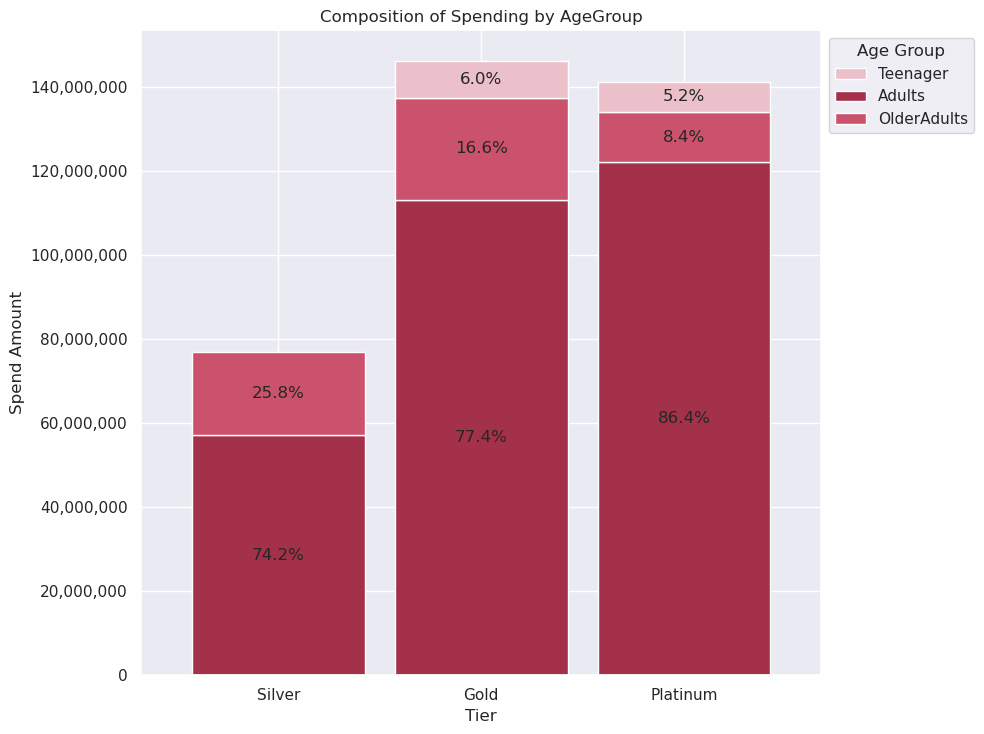

In [10]:
# Sorting the data by 'Tier' and 'AgeGroup'
amount_sum_by_agegroup_type = Cus_N_Spend_df.groupby(['AgeGroup', 'Tier'])['Spend Amt'].sum().reset_index()
amount_sum_by_agegroup_type.sort_values(['Tier', 'AgeGroup'], inplace=True)


#color_palette
stack_color_palette=['#A4314A','#CB526C','#ECC0CA']


# Create the pivot data again
pivot_data = amount_sum_by_agegroup_type.pivot(index='Tier', columns='AgeGroup', values='Spend Amt')

# Create the plot
ax = pivot_data.loc[['Silver', 'Gold', 'Platinum']].plot(kind='bar',stacked=True,figsize=(10,7.5),color=stack_color_palette, width=0.85)

# Set labels and title
plt.xlabel('Tier')
plt.ylabel('Spend Amount')
plt.title('Composition of Spending by AgeGroup')

# Set the order of x-axis ticks
preferred_order_tier = ['Silver', 'Gold', 'Platinum']
ax.set_xticklabels(preferred_order_tier)

# Rotate x-axis labels for better visibility
plt.xticks(rotation=0)

# Format y-axis ticks with thousands separator
from matplotlib import ticker
formatter = ticker.StrMethodFormatter('{x:,.0f}')
plt.gca().yaxis.set_major_formatter(formatter)

# Set the order and title for legends
handles, labels = ax.get_legend_handles_labels()
preferred_order_agegroup = ['Teenager', 'Adults', 'OlderAdults']
labels, handles = zip(*sorted(zip(labels, handles), key=lambda x: preferred_order_agegroup.index(x[0])))
ax.legend(handles, labels, title='Age Group', loc='upper left', bbox_to_anchor=(1, 1))

# Annotate the bars
for idx, label in enumerate(preferred_order_tier):
    total = pivot_data.loc[label].sum()  # total amount for this tier
    y_offset = 0  # To keep track of where to put text in the y-axis
    for col in pivot_data.columns:
        value = pivot_data.loc[label, col]
        if value == 0:  # Skip zero values
            continue
        percentage = (value / total) * 100  # Calculate the percentage
        y_pos = y_offset + (value / 2)  # Position to place text in y-axis
        ax.text(idx, y_pos, f"{percentage:.1f}%", ha='center', va='center')
        y_offset += value # Increase the y_offset for next iteration

    
plt.tight_layout(rect=[0, 0, 1, 1])
plt.show()


<h2>What is their spending habit?

In [11]:
sorted_tiers = ['Silver', 'Gold', 'Platinum']

grouped_data = Cus_N_Spend_df.groupby('Tier')['Type'].value_counts()
grouped_sum = Cus_N_Spend_df.groupby('Tier')['Type'].count()
grouped_Amount_sum = Cus_N_Spend_df.groupby('Tier')['Spend Amt'].sum()

table = grouped_data.unstack().fillna(0)
table['Total Count'] = grouped_sum
table['Spend Amt'] =  grouped_Amount_sum.apply(lambda x: "{:,.0f}".format(x))

sorted_table = table.reindex(sorted_tiers)
sorted_table.index.name = None

sorted_table.rename(columns={'Type': 'Tier'}, inplace=True)
sorted_table.rename_axis(columns=None, inplace=True)
sorted_table
# sorted_table.describe()

,AIR TICKET,AUTO,BIKE,BUS TICKET,CAMERA,CAR,CLOTHES,FOOD,JEWELLERY,MOVIE TICKET,PETROL,RENTAL,SANDALS,SHOPPING,TRAIN TICKET,Total Count,Spend Amt
Silver,31,6,7,18,37,5,21,30,19,19,45,17,8,22,35,320,"77,128,966"
Gold,63,14,17,45,75,12,33,62,31,25,83,34,11,45,60,610,"146,200,355"
Platinum,53,20,25,36,48,13,41,68,45,32,72,25,9,46,37,570,"141,314,753"


<h2> How many spent within their credit card monthly? </h2>

In [12]:
Cus_N_Spend_df=Cus_N_Spend_df.rename(columns={"Month": "Date"})

In [13]:
# Split the 'Month' column into a DataFrame with 'Year', 'Month', and 'Day' columns
split_date = Cus_N_Spend_df['Date'].str.split('-', expand=True)
split_date.columns = ['Day', 'Month', 'Year']

# Add the new columns to the original DataFrame
Cus_N_Spend_df = pd.concat([Cus_N_Spend_df, split_date], axis=1)

In [14]:
Cus_Spending_Date_df = Cus_N_Spend_df.drop(['Date','Limit','Segment'], axis=1)

df=pd.merge(Cus_N_Spend_df,Repay_cy_df,on='Customer',how='inner')
#df_grouped = df.groupby(['Customer','Month'])['Amount'].apply(list).reset_index()

#df_grouped
#df

In [15]:
df.columns

Index(['No', 'Customer', 'Age', 'City', 'Tier', 'Limit', 'Company', 'Segment',
       'AgeGroup', 'Sl No:', 'Date_x', 'Type', 'Spend Amt', 'Day', 'Month',
       'Year', 'SL No:', 'Date_y', 'Repay Amt'],
      dtype='object')

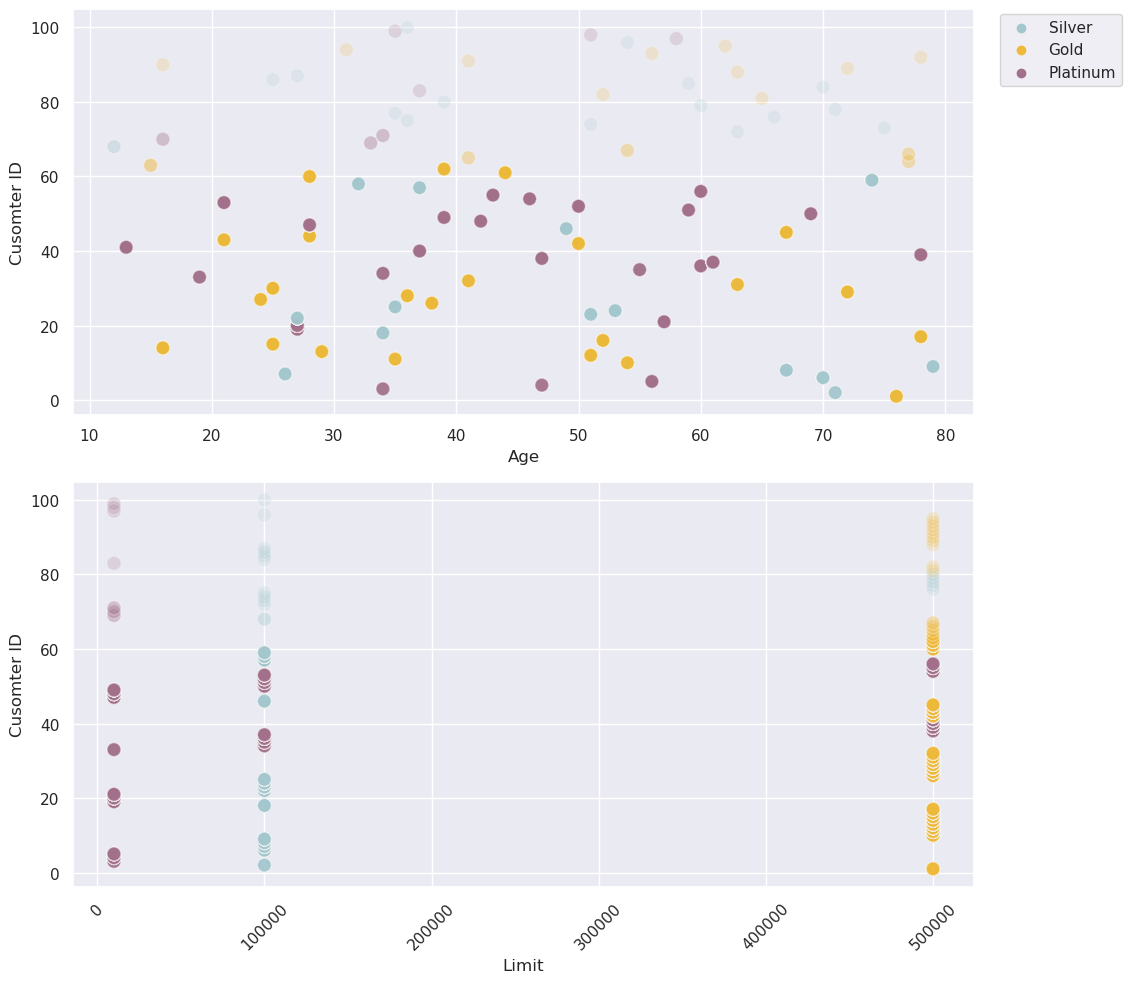

In [16]:
# Create a figure and a grid of subplots
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10,10))

#color plattee
color_palette=['#F0B93A','#A4C7CE','#A2708A']

# Create the first scatter plot on the first subplot
sns.scatterplot(x='Age', y='No', hue='Tier', data=Cus_N_Spend_df,s=100,alpha=0.2,palette=color_palette,ax=axes[0])

sns.scatterplot(x='Limit', y='No', hue='Tier', data=Cus_N_Spend_df,s=100,alpha=0.2,palette=color_palette,ax=axes[1])

# Remove the legend from the first subplot
axes[0].get_legend().remove()
axes[1].get_legend().remove()

# Add the legend outside the subplots
handles, labels = axes[0].get_legend_handles_labels()

preferred_order = ['Silver', 'Gold', 'Platinum']
sorted_handles, sorted_labels = zip(*sorted(zip(handles, labels), key=lambda x: preferred_order.index(x[1])))

fig.legend(sorted_handles,sorted_labels, loc='upper left', bbox_to_anchor=(1, 0.985))

ylabel = "Cusomter ID"
axes[0].set_ylabel(ylabel = ylabel)
axes[1].set_ylabel(ylabel = ylabel)
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45)

plt.tight_layout()
plt.show()

<h2>Identify the most popular products/services for which the credit card is used</h2>

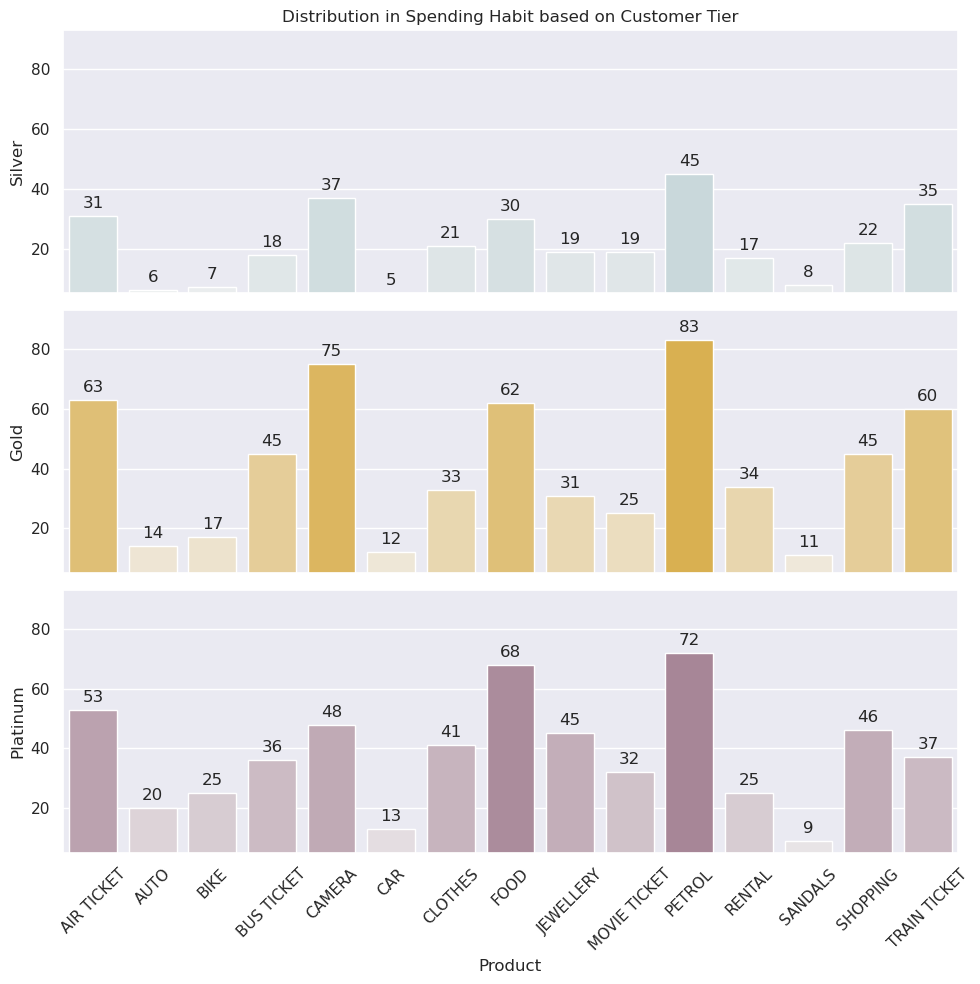

In [17]:
#What are their spending habit in differnt Teir?

# Assuming 'Type' is the column containing the type of spend
data_merged = Cus_N_Spend_df.groupby(['Tier', 'Type']).size().reset_index(name='Count')
order = data_merged['Type'].value_counts().index

# Filter data by a specific product, e.g., 'Platinum'
filtered_data_ax1 = data_merged[data_merged['Tier'] == 'Silver']
filtered_data_ax2 = data_merged[data_merged['Tier'] == 'Gold']
filtered_data_ax3 = data_merged[data_merged['Tier'] == 'Platinum']


max_count = filtered_data_ax2['Count'].max()

# Set up the matplotlib figure
f,(ax1,ax2,ax3) = plt.subplots(3,1,figsize=(10, 10), sharex=True)


# Create the Seaborn color palette
grad_color_s = sns.light_palette("#A4C7CE", reverse=False, as_cmap=True)
grad_color_g = sns.light_palette("#F0B93A", reverse=False, as_cmap=True)
grad_color_p = sns.light_palette("#A2708A", reverse=False, as_cmap=True)


# Normalize the 'Count' data and map to the color palette
palette_s = [grad_color_s(count/max_count) for count in filtered_data_ax1['Count']]
palette_g = [grad_color_g(count/max_count) for count in filtered_data_ax2['Count']]
palette_p = [grad_color_p(count/max_count) for count in filtered_data_ax3['Count']]


sns.barplot(data=filtered_data_ax1, x='Type', y='Count',palette=palette_s,ax=ax1)
ax1.set_ylabel("Silver")


sns.barplot(data=filtered_data_ax2, x='Type', y='Count',palette=palette_g,ax=ax2)
ax2.set_ylabel("Gold")

sns.barplot(data=filtered_data_ax3, x='Type', y='Count',palette=palette_p,ax=ax3)
ax3.set_ylabel("Platinum")


ax1.set_title('Distribution in Spending Habit based on Customer Tier')
ax1.set_xlabel('')
ax2.set_xlabel('')
ax3.set_xlabel('Product')

plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility

# Set y-axis limits to min and max values
ax1.set_ylim(data_merged['Count'].min(), data_merged['Count'].max()+10)
ax2.set_ylim(data_merged['Count'].min(), data_merged['Count'].max()+10)
ax3.set_ylim(data_merged['Count'].min(), data_merged['Count'].max()+10)


# Annotate values on the bars
def annotate_bars(ax):
    for p in ax.patches:
        ax.annotate(format(p.get_height(), '.0f'), 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha = 'center', va = 'center', 
                    xytext = (0, 9), 
                    textcoords = 'offset points')

annotate_bars(ax1)
annotate_bars(ax2)
annotate_bars(ax3)

# Finalize the plot
plt.tight_layout(h_pad=1)
plt.show()


In [18]:
Cus_N_Spend_df.head()

,No,Customer,Age,City,Tier,Limit,Company,Segment,AgeGroup,Sl No:,Date,Type,Spend Amt,Day,Month,Year
0,1,A1,76,BANGALORE,Gold,500000.0,C1,Self Employed,OlderAdults,1,12-Jan-04,JEWELLERY,485470.80,12,Jan,04
1,1,A1,76,BANGALORE,Gold,500000.0,C1,Self Employed,OlderAdults,2,3-Jan-04,PETROL,410556.13,3,Jan,04
2,1,A1,76,BANGALORE,Gold,500000.0,C1,Self Employed,OlderAdults,3,15-Jan-04,CLOTHES,23740.46,15,Jan,04
3,1,A1,76,BANGALORE,Gold,500000.0,C1,Self Employed,OlderAdults,4,25-Jan-04,FOOD,484342.47,25,Jan,04
4,1,A1,76,BANGALORE,Gold,500000.0,C1,Self Employed,OlderAdults,5,17-Jan-05,CAMERA,369694.07,17,Jan,05


<h2> What product is spend on the most on each of the city? </h2>

In [19]:
# Cus_N_Spend_df

In [20]:
#data
amount_sum_by_city_type=Cus_N_Spend_df.groupby(['City','Type'])['Spend Amt'].sum().reset_index()
tier_counts_by_city = Cus_N_Spend_df.groupby(['City', 'Type']).size().reset_index(name='Tier_Count')

result_df = pd.merge(amount_sum_by_city_type, tier_counts_by_city, on=['City', 'Type'])

fig = px.treemap(result_df,path=['City','Type'],values='Spend Amt',custom_data='Tier_Count')


# Update hover template for formatting
fig.update_traces(
#     hovertemplate='<b>%{label}</b><br>Value: $%{Amount[0]:,.2f}'
    hovertemplate='<b>%{label}</b><br>Amount: $%{value:,.2f}<br>Number of Tier: %{customdata[0]}'
)

# Update layout for better visualization
fig.update_layout(
    margin=dict(l=20, r=20, t=30, b=20),
    title='Sample Treemap',
)

# Show the plot
fig.show()


In [21]:
# Create a new DataFrame that sums up the Amount and Tier_Count for each City
# summed_df = result_df.groupby('City').agg({
#     'Amount': 'sum',
#     'Tier_Count': 'sum'
# }).reset_index()
#summed_df 

In [22]:
#How much is their credit card limited? Avg Med?

# Define is_skewed function
def is_skewed(mean, median):
    if mean > median:
        return 'Right'
    elif mean < median:
        return 'Left'
    else:
        return 'Symmetric'

# Group by 'Tier' and then aggregate
summary_stats = Cus_cy_df.groupby('Tier')['Limit'].agg(['count','median','mean','std', 'sum']).round(2).reset_index() 
summary_stats['skew'] = summary_stats.apply(lambda row: is_skewed(row['mean'], row['median']), axis=1)
#summary_stats['var'] = summary_stats['var'].apply(lambda x:'{:,.0f}'.format(x))

summary_stats

#how does bank deal with values that have more then 2 decimal place?

,Tier,count,median,mean,std,sum,skew
0,Gold,38,500000.0,500000.00,0.00,19000000.0,Symmetric
1,Platinum,32,10002.0,139688.47,197344.55,4470031.0,Right
2,Silver,30,100001.5,166667.67,151619.15,5000030.0,Right


In [23]:
mode_values = Cus_cy_df.groupby('Tier')['Limit'].describe().round(2).reset_index()
mode_values

,Tier,count,mean,std,min,25%,50%,75%,max
0,Gold,38.0,500000.00,0.00,500000.0,500000.0,500000.0,500000.0,500000.0
1,Platinum,32.0,139688.47,197344.55,10000.0,10001.0,10002.0,100003.0,500000.0
2,Silver,30.0,166667.67,151619.15,100000.0,100000.0,100001.5,100003.0,500000.0


In [24]:
#Clean_Repay_df
#Cus_df.nunique()
#Cus_df.info()
#Spend_df

# SandBox Area

In [25]:
# #Using PLT
# # Count the occurrences of each tier
# tier_counts = Cus_df['Tier'].value_counts().sort_values(ascending=True)

# # Extract labels and counts
# labels = tier_counts.index
# counts = tier_counts.values

# # Create a bar chart
# plt.figure(figsize=(8, 6))
# plt.bar(labels, counts, color=['gold', 'silver', 'blue'])

# # Set labels and title
# plt.xlabel('Customer Tier')
# plt.ylabel('Number of Customers')
# plt.title('Distribution of Customer Tiers')

# # Show the plot
# plt.show()

In [26]:
# Price_list = {'Cheeseburger': 8, 'Fries': 5, 'Lasagna': 12, 'Soup': 5, 'Spaghetti': 10}

# print(Price_list['Spaghetti'])
# Price_list.get('Spaghetti')


# #reassign all the key to different meaning.


In [27]:
# nums = [1,35,12,24,31,51,70,100]


# def count (number):
#     number = sorted(number)
#     x = 0
#     while number[x]<20:
#         x+=1
#     return x
    
# count (nums)


